In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
data = pd.read_csv("resources/UVXY.csv",parse_dates = True, index_col="Date")

In [17]:
uvxy = pd.DataFrame(data["Adj Close"])

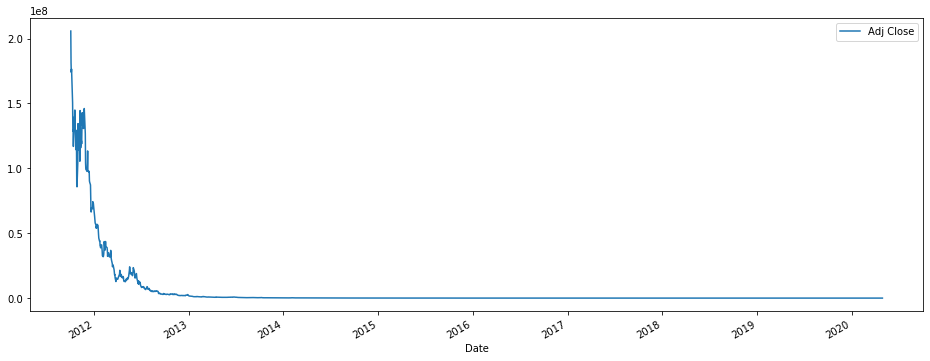

In [19]:
uvxy.plot(figsize = (16,6))

### Because UVXY very unstable from 2011 - 2017 we will only create out movel from 2013 on where there is less of a massive change. If this model fails we will circle back to add all data

In [424]:
working_data = uvxy.loc["2017-11-1":]

In [425]:
working_data

,Adj Close
Date,
2017-11-01,77.250000
2017-11-02,75.650002
2017-11-03,75.199997
2017-11-06,73.800003
2017-11-07,74.599998
...,...
2020-04-23,53.099998
2020-04-24,48.700001
2020-04-27,43.099998


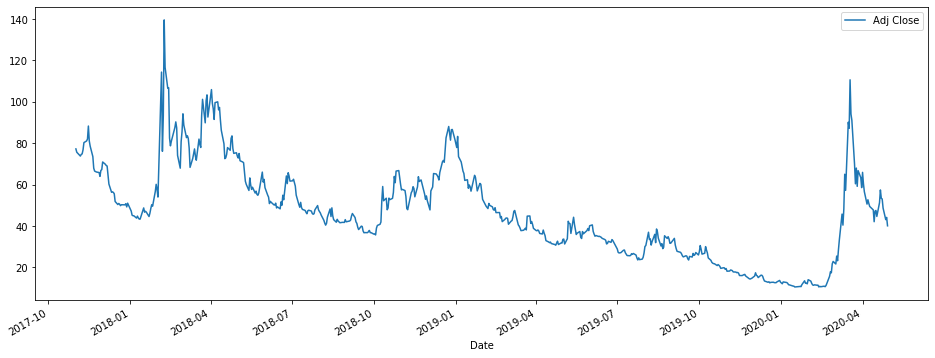

In [426]:
working_data.plot(figsize = (16,6))

In [427]:
working_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 626 entries, 2017-11-01 to 2020-04-29
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  626 non-null    float64
dtypes: float64(1)
memory usage: 9.8 KB


## Sample Set
- We will look at 1 year of data from UVXY
- 253 trading days (assuming 253 trading days)

In [428]:
sampe_size = 253

In [429]:
sample_index = len(working_data) - sampe_size

## train/Test

In [430]:
train = working_data.iloc[:sample_index]

In [431]:
test = working_data.iloc[sample_index:]

In [432]:
train.shape

(373, 1)

In [433]:
test.shape

(253, 1)

### Scaling Data

In [434]:
from sklearn.preprocessing import MinMaxScaler

In [435]:
scalar = MinMaxScaler()

In [436]:
train_scaled = scalar.fit_transform(train)

In [437]:
test_scaled = scalar.transform(test)

### Batch generation with TIme Series generator
- Length will be 30days

In [457]:
length = 14

In [458]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [459]:
gen = TimeseriesGenerator(train_scaled,train_scaled, length=length, batch_size=1)

### Validation Gen 

In [460]:
valid_gen = TimeseriesGenerator(test_scaled,test_scaled, length=length, batch_size=1)

## early Stopping

In [461]:
from tensorflow.keras.callbacks import EarlyStopping

In [462]:
stop = EarlyStopping(monitor="val_loss",mode="min", patience=2)

### model Creation

In [463]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [464]:
n_features= 1

In [465]:
model = Sequential()
model.add(LSTM(units = 200, activation= "relu", input_shape= (length, n_features)))
model.add(Dense(units = 1))
model.compile(optimizer = "adam", loss = "mse")

## fitting model

In [466]:
model.fit_generator(generator=gen, validation_data=valid_gen,epochs=30, callbacks=[stop])

Epoch 1/30
359/359 [==============================] - 19s 52ms/step - loss: 0.0094 - val_loss: 0.0103
Epoch 2/30
359/359 [==============================] - 19s 53ms/step - loss: 0.0057 - val_loss: 0.0077
Epoch 3/30
359/359 [==============================] - 19s 52ms/step - loss: 0.0049 - val_loss: 0.0100
Epoch 4/30
359/359 [==============================] - 19s 52ms/step - loss: 0.0039 - val_loss: 0.0056
Epoch 5/30
359/359 [==============================] - 18s 52ms/step - loss: 0.0036 - val_loss: 0.0060
Epoch 6/30
359/359 [==============================] - 19s 52ms/step - loss: 0.0034 - val_loss: 0.0040
Epoch 7/30
359/359 [==============================] - 18s 51ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 8/30
359/359 [==============================] - 18s 51ms/step - loss: 0.0033 - val_loss: 0.0045
Epoch 9/30
359/359 [==============================] - 19s 52ms/step - loss: 0.0032 - val_loss: 0.0056


# Model Performance

In [467]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 200)               161600    
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


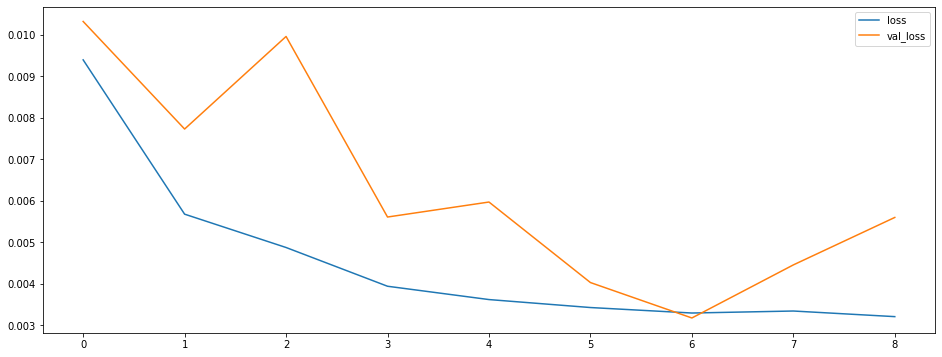

In [468]:
pd.DataFrame(model.history.history).plot(figsize = (16,6))

### predicitons

In [469]:
test_predictions = []
batch = train_scaled[-length:]
current_batch = batch.reshape((1,length,n_features))
for i in range(len(test)):
    current_prediciton = model.predict(current_batch)[0]
    test_predictions.append(current_prediciton)
    current_batch = np.append(current_batch[:,1:,:], [[current_prediciton]], axis = 1)

In [470]:
test_predictions

[array([0.02724995], dtype=float32),
 array([0.03476964], dtype=float32),
 array([0.04316077], dtype=float32),
 array([0.05238009], dtype=float32),
 array([0.06237206], dtype=float32),
 array([0.07300685], dtype=float32),
 array([0.08393493], dtype=float32),
 array([0.09483764], dtype=float32),
 array([0.10548706], dtype=float32),
 array([0.11573215], dtype=float32),
 array([0.12543842], dtype=float32),
 array([0.13452725], dtype=float32),
 array([0.14300404], dtype=float32),
 array([0.15097602], dtype=float32),
 array([0.1584252], dtype=float32),
 array([0.16535941], dtype=float32),
 array([0.17184865], dtype=float32),
 array([0.17793557], dtype=float32),
 array([0.18365598], dtype=float32),
 array([0.18903801], dtype=float32),
 array([0.19411254], dtype=float32),
 array([0.19890425], dtype=float32),
 array([0.20343372], dtype=float32),
 array([0.2077181], dtype=float32),
 array([0.21177146], dtype=float32),
 array([0.21560737], dtype=float32),
 array([0.21923387], dtype=float32),
 ar

## True_predictions

In [471]:
true_predictions = scalar.inverse_transform(test_predictions)

In [472]:
true_predictions

array([[33.71479474],
       [34.53293687],
       [35.44589192],
       [36.44895381],
       [37.53608057],
       [38.69314588],
       [39.88212096],
       [41.06833587],
       [42.22699283],
       [43.34165808],
       [44.39770069],
       [45.38656533],
       [46.30884051],
       [47.17619112],
       [47.98666191],
       [48.74110405],
       [49.44713415],
       [50.1093906 ],
       [50.73177088],
       [51.31733589],
       [51.86944486],
       [52.39078257],
       [52.88358959],
       [53.34973035],
       [53.79073531],
       [54.20808304],
       [54.60264577],
       [54.97514334],
       [55.32695705],
       [55.65946819],
       [55.97385056],
       [56.27124552],
       [56.55247988],
       [56.81842914],
       [57.06993633],
       [57.30774724],
       [57.5325979 ],
       [57.74516924],
       [57.94619731],
       [58.13640517],
       [58.3162857 ],
       [58.48637715],
       [58.64721451],
       [58.79928743],
       [58.94305307],
       [59

In [473]:
test["predictions"] = true_predictions

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


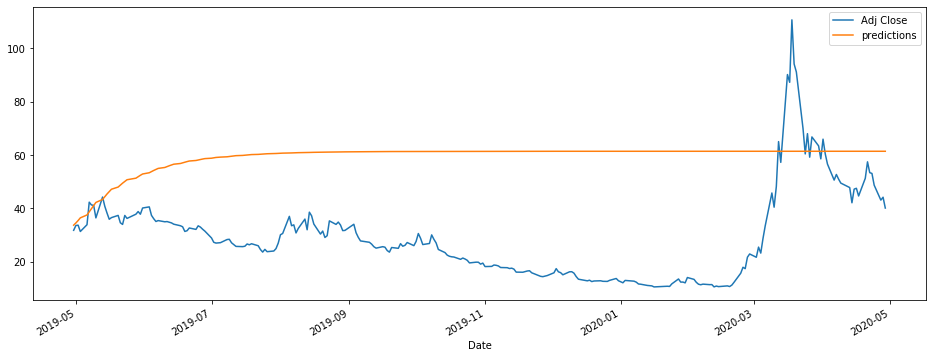

In [474]:
test.plot(figsize = (16,6))

In [475]:
test

,Adj Close,predictions
Date,,
2019-04-30,31.790001,33.714795
2019-05-01,33.590000,34.532937
2019-05-02,33.709999,35.445892
2019-05-03,31.340000,36.448954
2019-05-06,33.880001,37.536081
...,...,...
2020-04-23,53.099998,61.398230
2020-04-24,48.700001,61.398233
2020-04-27,43.099998,61.398236


### Forecast

In [476]:
main_scalar = MinMaxScaler()

In [477]:
working_scaled = main_scalar.fit_transform(working_data)

In [479]:
forecast = []
period = length
batch = working_scaled[-length:]
curr_b = batch.reshape((1,length,n_features))
for i in range(period):
    pree =model.predict(curr_b)[0]
    forecast.append(pree)
    curr_b = np.append(curr_b[:,1:,:], [[pree]], axis = 1)

In [480]:
forecast

[array([0.23284316], dtype=float32),
 array([0.22797626], dtype=float32),
 array([0.2264818], dtype=float32),
 array([0.22747186], dtype=float32),
 array([0.23001176], dtype=float32),
 array([0.23344392], dtype=float32),
 array([0.23731592], dtype=float32),
 array([0.24114141], dtype=float32),
 array([0.24464077], dtype=float32),
 array([0.24783856], dtype=float32),
 array([0.25063017], dtype=float32),
 array([0.25302732], dtype=float32),
 array([0.25512403], dtype=float32),
 array([0.25687215], dtype=float32)]

In [481]:
true_forecast = main_scalar.inverse_transform(forecast)

In [482]:
true_forecast

array([[40.60978312],
       [39.98209927],
       [39.78935782],
       [39.91704624],
       [40.24461753],
       [40.68726253],
       [41.1866353 ],
       [41.6800082 ],
       [42.13132053],
       [42.54373941],
       [42.90377379],
       [43.21293421],
       [43.48334724],
       [43.70880161]])

In [483]:
working_data.tail()

,Adj Close
Date,
2020-04-23,53.099998
2020-04-24,48.700001
2020-04-27,43.099998
2020-04-28,44.180000
2020-04-29,40.119999


In [486]:
date_index = pd.date_range(start="2020-4-30", periods=period, freq="B")

In [487]:
date_index

DatetimeIndex(['2020-04-30', '2020-05-01', '2020-05-04', '2020-05-05',
               '2020-05-06', '2020-05-07', '2020-05-08', '2020-05-11',
               '2020-05-12', '2020-05-13', '2020-05-14', '2020-05-15',
               '2020-05-18', '2020-05-19'],
              dtype='datetime64[ns]', freq='B')

In [488]:
forecast_df = pd.DataFrame(true_forecast, index=date_index)

In [489]:
forecast_df

,0
2020-04-30,40.609783
2020-05-01,39.982099
2020-05-04,39.789358
2020-05-05,39.917046
2020-05-06,40.244618
2020-05-07,40.687263
2020-05-08,41.186635
2020-05-11,41.680008
2020-05-12,42.131321
2020-05-13,42.543739


In [490]:
model.save("UVXY_final.h5")